In [23]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [24]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet50)

In [25]:
m = learn.model.eval()

In [26]:
def linear_decorelate_color(t):
    # from https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/color.py
    color_correlation_svd_sqrt = np.asarray([[0.26, 0.09, 0.02],
                                             [0.27, 0.00, -0.05],
                                             [0.27, -0.09, 0.03]]).astype("float32")
    max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))

    t_flat = t.permute(0,2,3,1)
    color_correlation_normalized = tensor(color_correlation_svd_sqrt / max_norm_svd_sqrt)
    t_flat = torch.matmul(t_flat, color_correlation_normalized.T)
    t = t_flat.permute(0,3,1,2)
    return t

def show_image_buf(img_buf, jitter, label=None, decorrelate=True):
    img = img_buf.detach()
    size = img.shape[-1]
    x_off,y_off = jitter//2,jitter//2
    if decorrelate: img = linear_decorelate_color(img)
    img = torch.sigmoid(img)
    img = img[:,:,x_off:x_off+size-jitter,y_off:y_off+size-jitter] # jitter
    img = Image(img[0])
    img.show(figsize=(img.shape[1]/25,img.shape[2]/25))
    plt.title(label)
    plt.show()
    
def visualize_feature(model, layer, feature,
                      size=200, jitter=25,
                      steps=2000, lr=0.05,
                      decorrelate=True, debug=False):
    img_buf = torch.empty(1,3,size+jitter,size+jitter).normal_(mean=0,std=0.01)
    img_buf = torch.sigmoid(tensor(img_buf))
    img_buf.requires_grad_()
    opt = torch.optim.Adam([img_buf], lr=lr)

    with hook_output(layer,detach=False) as hook_a:
        for i in range(steps):
            x_off, y_off = int(np.random.random()*jitter),int(np.random.random()*jitter)
            img = img_buf[:,:,x_off:x_off+size+1,y_off:y_off+size+1] # jitter
            if decorrelate: img = linear_decorelate_color(img) # decorrelate color
            model(img.cuda())
            opt.zero_grad()
            loss = -1*hook_a.stored[0][feature].mean()
            loss.backward()
            opt.step()
            if debug and i%(steps/10)==0: 
                show_image_buf(img_buf, jitter, label=f"step: {i} loss: {loss}", decorrelate=decorrelate)

    show_image_buf(img_buf, jitter, label=f"Feature {feature}",decorrelate=decorrelate)

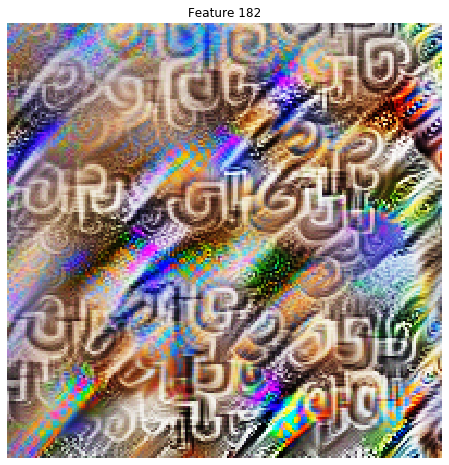

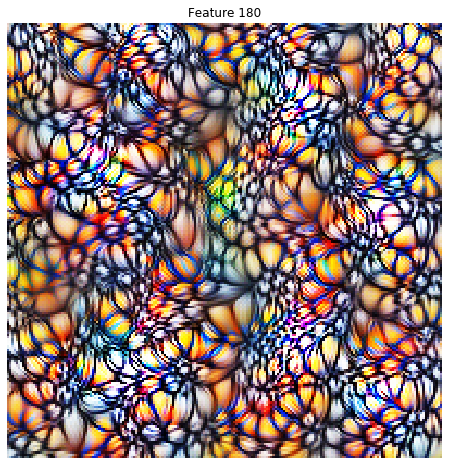

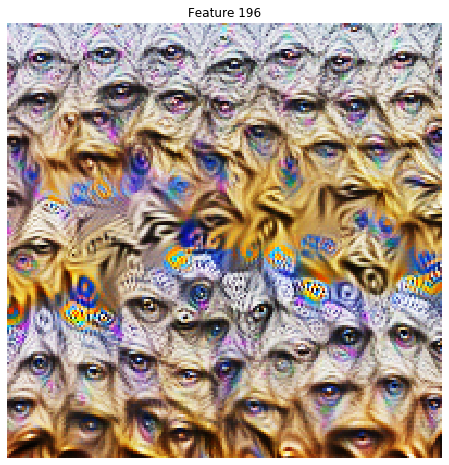

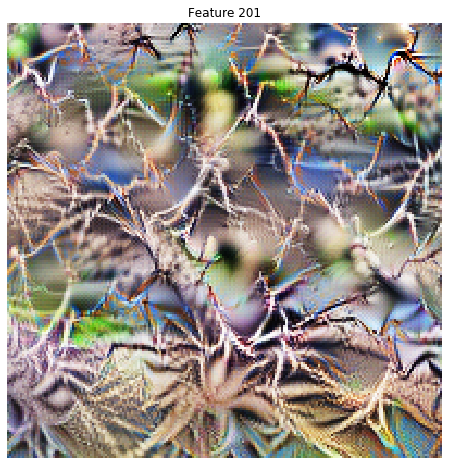

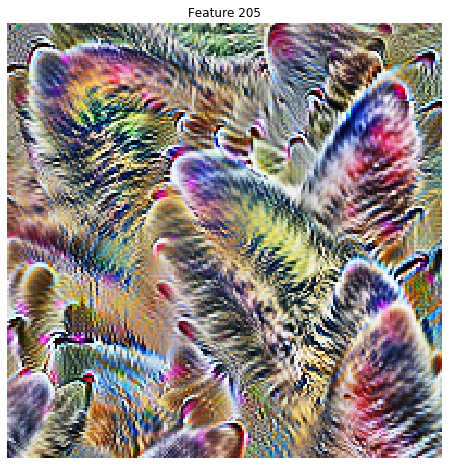

In [27]:
for feature in [182, 180, 196, 201, 205]:
    visualize_feature(m, m[0][6][5], feature)